In [2]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import torch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from era_data import TabletEraDataset
from era_model import EraClassifier
from glob import glob
from era_data import TabletPeriodDataset
import pandas as pd
from matplotlib import pyplot as plt
from itertools import islice
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm, trange
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression

# Load data and model

In [5]:
! ls lightning_logs

period_clf_bs16_lr5e-05_3epochs-resnet50-103384_samples-preprocessed2
period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-masked
period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-preprocessed2
period_clf_bs16_lr5e-05_5epochs-resnet50-97640_samples-masked
period_clf_bs16_lr5e-05_7epochs-resnet50-97640_samples-masked
version_727469
version_729970


In [6]:
VERSION_NAME = 'period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-preprocessed2'

In [7]:
ckpt_fns = glob('lightning_logs/*/checkpoints/*')
ckpt_fns

['lightning_logs/version_727469/checkpoints/epoch=1-step=9650.ckpt',
 'lightning_logs/version_729970/checkpoints/epoch=2-step=18094.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-preprocessed2/checkpoints/epoch=2-step=18214.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-masked/checkpoints/epoch=2-step=18214.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_5epochs-resnet50-97640_samples-masked/checkpoints/epoch=4-step=30358.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_7epochs-resnet50-97640_samples-masked/checkpoints/epoch=6-step=42502.ckpt',
 'lightning_logs/period_clf_bs16_lr5e-05_7epochs-resnet50-97640_samples-masked/checkpoints/epoch=5-step=31574.ckpt']

In [8]:
CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/period_clf_bs16_lr5e-05_3epochs-resnet50-97640_samples-preprocessed2/checkpoints/epoch=2-step=18214.ckpt'

In [9]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES) + 2
num_classes

24

In [10]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN, num_classes=num_classes)

/home/kapond/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/kapond/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 899 ms, sys: 563 ms, total: 1.46 s
Wall time: 7.68 s


In [11]:
model.to(device);

In [12]:
model.eval();

In [13]:
train_ids = pd.read_csv(f'output/clf_ids/period-train-{VERSION_NAME}.csv', header=None)[0].astype(str)
test_ids = pd.read_csv(f'output/clf_ids/period-test-{VERSION_NAME}.csv', header=None)[0].astype(str)

In [16]:
len(train_ids), len(test_ids)

(97140, 500)

In [17]:
ds_train = TabletPeriodDataset(IDS=train_ids)
ds_test = TabletPeriodDataset(IDS=test_ids)

Filtering 97640 IDS down to provided 97140...
Filtering 97640 IDS down to provided 500...


# Calculate predictions

In [18]:
from itertools import islice
import scipy

In [19]:
# dl_train = DataLoader(ds_train, batch_size=16, shuffle=False, num_workers=1)
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [20]:
def dl2data(dl, MAX_N=None):
    logits = []
    y_true = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            y_true.append(y.numpy())
            logits.append(model(X.to(device)).cpu().numpy())
    y_true = np.hstack(y_true)
    logits = np.vstack(logits)
    return logits, y_true

In [21]:
logits, y_true = dl2data(dl_test)

  0%|          | 0/31 [00:00<?, ?it/s]

Key Not Found in Period Dictionary: '420722'


In [22]:
y_true.shape, logits.shape

((486,), (486, 24))

In [23]:
y_pred = logits.argmax(axis=-1)
y_prob = scipy.special.softmax(logits, axis=-1)

In [24]:
y_pred.shape, y_prob.shape

((486,), (486, 24))

In [25]:
(y_pred == y_true).mean()

0.8930041152263375

# Check metrics

In [26]:
from collections import Counter

In [27]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
    
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Middle Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [28]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'
explain('Neo-Babylonian')

'Neo-Babylonian (I)'

In [29]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [30]:
idx2period[0], idx2period[5]

('other', 'Neo-Babylonian')

In [31]:
indices = list(set(y_true) | set(y_pred))
print(len(indices))
print(indices)
PERIOD_LABELS = [explain(idx2period[i]) for i in indices]
print(PERIOD_LABELS)

17
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 18, 19]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Uruk III (EB)', 'Lagash II (EB)', 'Ebla (EB)', 'ED I-II (EB)', 'Middle Elamite (MLB)']


In [32]:
print(classification_report(y_true, y_pred, target_names=PERIOD_LABELS))

                            precision    recall  f1-score   support

                 other (?)       0.00      0.00      0.00         1
               Ur III (EB)       0.98      0.94      0.96       145
          Neo-Assyrian (I)       1.00      1.00      1.00       121
      Old Babylonian (MLB)       0.85      0.86      0.85        97
   Middle Babylonian (MLB)       0.66      0.74      0.70        31
        Neo-Babylonian (I)       0.76      0.76      0.76        25
         Old Akkadian (EB)       0.77      0.83      0.80        12
            Achaemenid (I)       0.50      0.83      0.62         6
Early Old Babylonian (MLB)       0.58      0.58      0.58        12
              ED IIIb (EB)       0.90      0.82      0.86        11
     Middle Assyrian (MLB)       1.00      0.80      0.89        10
        Old Assyrian (MLB)       1.00      1.00      1.00         6
             Uruk III (EB)       1.00      1.00      1.00         2
            Lagash II (EB)       0.33      1.00

/storage/modules/packages/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/modules/packages/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/modules/packages/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [33]:
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_true).items() if v >= 10})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (9)


[(1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (8, 'Early Old Babylonian (MLB)'),
 (9, 'ED IIIb (EB)'),
 (10, 'Middle Assyrian (MLB)')]

In [34]:
y_true_c = y_true.copy()
y_true_c[~np.isin(y_true, COMMON_LABELS)] = 0
print((~np.isin(y_true, COMMON_LABELS)).mean(), 'changed to "other"')

0.04526748971193416 changed to "other"


In [35]:
y_pred_c = y_pred.copy()
y_pred_c[~np.isin(y_pred, COMMON_LABELS)] = 0
print((~np.isin(y_pred, COMMON_LABELS)).mean(), 'changed to "other"')

0.051440329218107 changed to "other"


In [36]:
indices_c = list(set(y_true_c) | set(y_pred_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

10
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)']


In [37]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                            precision    recall  f1-score   support

                 other (?)       0.72      0.82      0.77        22
               Ur III (EB)       0.98      0.94      0.96       145
          Neo-Assyrian (I)       1.00      1.00      1.00       121
      Old Babylonian (MLB)       0.85      0.86      0.85        97
   Middle Babylonian (MLB)       0.66      0.74      0.70        31
        Neo-Babylonian (I)       0.76      0.76      0.76        25
         Old Akkadian (EB)       0.77      0.83      0.80        12
Early Old Babylonian (MLB)       0.58      0.58      0.58        12
              ED IIIb (EB)       0.90      0.82      0.86        11
     Middle Assyrian (MLB)       1.00      0.80      0.89        10

                  accuracy                           0.89       486
                 macro avg       0.82      0.81      0.82       486
              weighted avg       0.90      0.89      0.89       486



In [38]:
cm = confusion_matrix(y_true_c, y_pred_c)
cm # rows: ground truth; cols: prediction

array([[ 18,   0,   0,   1,   0,   2,   0,   0,   1,   0],
       [  2, 136,   0,   3,   2,   0,   1,   1,   0,   0],
       [  0,   0, 121,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   0,  83,   7,   2,   0,   3,   0,   0],
       [  1,   0,   0,   6,  23,   1,   0,   0,   0,   0],
       [  4,   0,   0,   1,   1,  19,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,  10,   1,   0,   0],
       [  0,   0,   0,   4,   0,   1,   0,   7,   0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   9,   0],
       [  0,   0,   0,   0,   2,   0,   0,   0,   0,   8]])

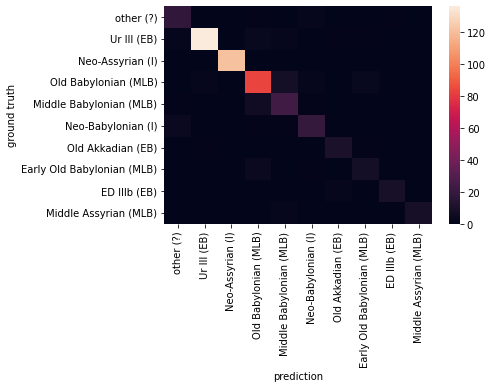

In [39]:
sns.heatmap(cm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth');

In [40]:
cm_rownorm = (cm / cm.sum(axis=1)[:, None])

In [41]:
cm

array([[ 18,   0,   0,   1,   0,   2,   0,   0,   1,   0],
       [  2, 136,   0,   3,   2,   0,   1,   1,   0,   0],
       [  0,   0, 121,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   0,  83,   7,   2,   0,   3,   0,   0],
       [  1,   0,   0,   6,  23,   1,   0,   0,   0,   0],
       [  4,   0,   0,   1,   1,  19,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,  10,   1,   0,   0],
       [  0,   0,   0,   4,   0,   1,   0,   7,   0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   9,   0],
       [  0,   0,   0,   0,   2,   0,   0,   0,   0,   8]])

In [42]:
cm_rownorm

array([[0.81818182, 0.        , 0.        , 0.04545455, 0.        ,
        0.09090909, 0.        , 0.        , 0.04545455, 0.        ],
       [0.0137931 , 0.93793103, 0.        , 0.02068966, 0.0137931 ,
        0.        , 0.00689655, 0.00689655, 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.02061856, 0.        , 0.8556701 , 0.07216495,
        0.02061856, 0.        , 0.03092784, 0.        , 0.        ],
       [0.03225806, 0.        , 0.        , 0.19354839, 0.74193548,
        0.03225806, 0.        , 0.        , 0.        , 0.        ],
       [0.16      , 0.        , 0.        , 0.04      , 0.04      ,
        0.76      , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.08333333, 0.        , 0.        , 0.        ,
        0.        , 0.83333333, 0.08333333, 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [43]:
cm.sum(axis=1)

array([ 22, 145, 121,  97,  31,  25,  12,  12,  11,  10])

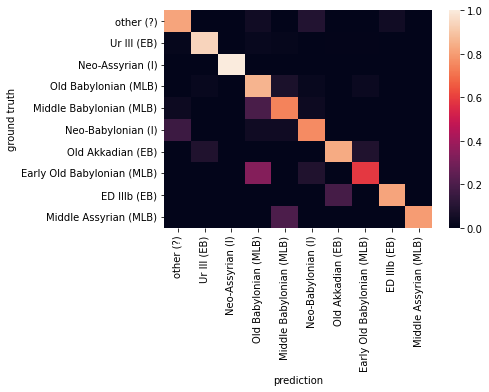

In [44]:
sns.heatmap(cm_rownorm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth');

In [45]:
cm_df = pd.DataFrame(cm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Early Old Babylonian (MLB),ED IIIb (EB),Middle Assyrian (MLB)
other (?),18,0,0,1,0,2,0,0,1,0
Ur III (EB),2,136,0,3,2,0,1,1,0,0
Neo-Assyrian (I),0,0,121,0,0,0,0,0,0,0
Old Babylonian (MLB),0,2,0,83,7,2,0,3,0,0
Middle Babylonian (MLB),1,0,0,6,23,1,0,0,0,0
Neo-Babylonian (I),4,0,0,1,1,19,0,0,0,0
Old Akkadian (EB),0,1,0,0,0,0,10,1,0,0
Early Old Babylonian (MLB),0,0,0,4,0,1,0,7,0,0
ED IIIb (EB),0,0,0,0,0,0,2,0,9,0
Middle Assyrian (MLB),0,0,0,0,2,0,0,0,0,8


In [46]:
cm_rn_df = pd.DataFrame(cm_rownorm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_rn_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Early Old Babylonian (MLB),ED IIIb (EB),Middle Assyrian (MLB)
other (?),0.818182,0.000000,0.0,0.045455,0.000000,0.090909,0.000000,0.000000,0.045455,0.0
Ur III (EB),0.013793,0.937931,0.0,0.020690,0.013793,0.000000,0.006897,0.006897,0.000000,0.0
Neo-Assyrian (I),0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Old Babylonian (MLB),0.000000,0.020619,0.0,0.855670,0.072165,0.020619,0.000000,0.030928,0.000000,0.0
Middle Babylonian (MLB),0.032258,0.000000,0.0,0.193548,0.741935,0.032258,0.000000,0.000000,0.000000,0.0
Neo-Babylonian (I),0.160000,0.000000,0.0,0.040000,0.040000,0.760000,0.000000,0.000000,0.000000,0.0
Old Akkadian (EB),0.000000,0.083333,0.0,0.000000,0.000000,0.000000,0.833333,0.083333,0.000000,0.0
Early Old Babylonian (MLB),0.000000,0.000000,0.0,0.333333,0.000000,0.083333,0.000000,0.583333,0.000000,0.0
ED IIIb (EB),0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.181818,0.000000,0.818182,0.0
Middle Assyrian (MLB),0.000000,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.8


In [47]:
cm_df.loc['Early Old Babylonian (MLB)']

other (?)                     0
Ur III (EB)                   0
Neo-Assyrian (I)              0
Old Babylonian (MLB)          4
Middle Babylonian (MLB)       0
Neo-Babylonian (I)            1
Old Akkadian (EB)             0
Early Old Babylonian (MLB)    7
ED IIIb (EB)                  0
Middle Assyrian (MLB)         0
Name: Early Old Babylonian (MLB), dtype: int64

In [48]:
cm_rn_df.loc['Early Old Babylonian (MLB)']

other (?)                     0.000000
Ur III (EB)                   0.000000
Neo-Assyrian (I)              0.000000
Old Babylonian (MLB)          0.333333
Middle Babylonian (MLB)       0.000000
Neo-Babylonian (I)            0.083333
Old Akkadian (EB)             0.000000
Early Old Babylonian (MLB)    0.583333
ED IIIb (EB)                  0.000000
Middle Assyrian (MLB)         0.000000
Name: Early Old Babylonian (MLB), dtype: float64

# Hierarchical clustering on confusion matrix

In [49]:
from scipy.cluster import hierarchy

In [50]:
Y = hierarchy.distance.pdist(cm_rownorm, metric='euclidean')

In [51]:
Z = hierarchy.linkage(Y, method='single')

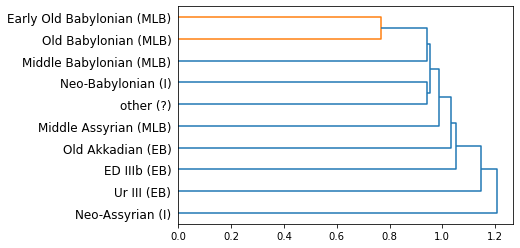

In [52]:
ax = hierarchy.dendrogram(Z, show_contracted=True, labels=PERIOD_LABELS_C, orientation='right')

# Clustering feature vectors using model as feature extractor

In [53]:
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt

In [54]:
activation = {}
def get_activation(name):
    def hook(model, inp, output):
        activation[name] = output.detach()
    return hook

In [55]:
model.core.avgpool.register_forward_hook(get_activation('ap'))
# model.core.fc.register_forward_hook(get_activation('fc'))

In [56]:
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [57]:
def extract_features(dl, MAX_N=None):
    outs = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            model(X.to(device))
            outs.append(activation['ap'].cpu().numpy()[..., 0, 0])
    return np.vstack(outs)
#     y_true = np.hstack(y_true)
#     logits = np.vstack(logits)
#     return logits, y_true

In [58]:
feats = extract_features(dl_test)

  0%|          | 0/31 [00:00<?, ?it/s]

Key Not Found in Period Dictionary: '420722'


In [59]:
feats.shape

(486, 2048)

In [60]:
%time F = TSNE(n_components=2, init='pca').fit_transform(feats)
# learning_rate='auto' -- https://www.pythonfixing.com/2021/11/fixed-sklearnmanifoldtsne-typeerror.html

/storage/modules/packages/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/storage/modules/packages/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


CPU times: user 5.87 s, sys: 0 ns, total: 5.87 s
Wall time: 1.75 s


In [76]:
%time F2 = Isomap(n_components=2).fit_transform(feats)

CPU times: user 197 ms, sys: 19.5 ms, total: 217 ms
Wall time: 343 ms


In [62]:
F.shape

(486, 2)

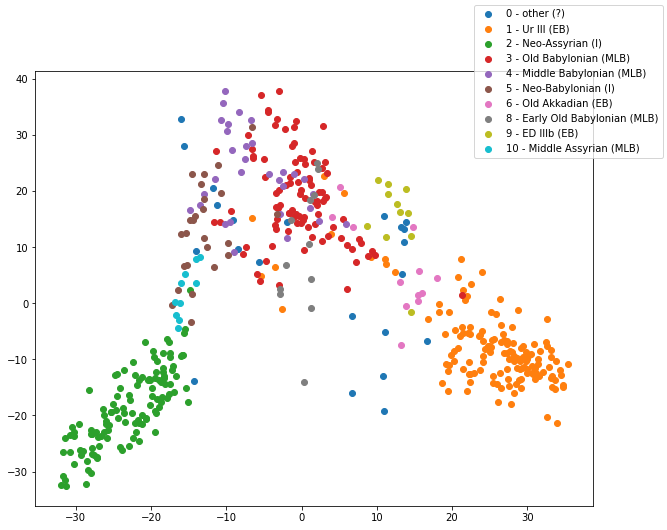

In [79]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
for period in set(y_true_c):
    ax.scatter(F[y_true_c == period, 0], F2[y_true_c == period, 1], label=f'{period} - {explain(idx2period[period])}')
fig.legend();

In [64]:
# green
np.where(y_true == 2)

(array([  0,   4,   5,  10,  16,  17,  20,  22,  30,  33,  36,  37,  44,
         46,  48,  49,  62,  64,  65,  68,  73,  74,  77,  78,  79,  80,
         93,  95, 100, 112, 114, 115, 118, 120, 121, 123, 125, 126, 130,
        132, 137, 139, 143, 167, 168, 170, 175, 176, 183, 191, 193, 196,
        199, 202, 203, 211, 215, 219, 221, 229, 230, 232, 234, 240, 242,
        255, 256, 262, 263, 265, 272, 274, 282, 289, 294, 298, 302, 303,
        304, 309, 314, 316, 317, 323, 330, 332, 334, 340, 352, 353, 356,
        357, 361, 372, 374, 386, 400, 401, 403, 407, 409, 413, 414, 420,
        429, 433, 434, 436, 437, 440, 450, 453, 455, 457, 461, 462, 469,
        471, 473, 474, 484]),)

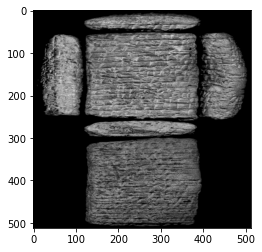

In [65]:
ID = np.random.choice(np.where(y_true == 11)[0])
plt.imshow(ds_test[ID][0], cmap='gray');

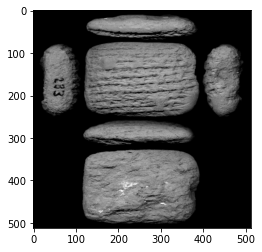

In [66]:
ID = np.random.choice(np.where(y_true == 5)[0])
plt.imshow(ds_test[ID][0], cmap='gray');

In [67]:
F[y_true_c == period, 0]

array([-13.5576105, -16.121872 , -16.262758 , -16.884296 , -15.437221 ,
       -16.454313 , -16.066439 , -14.066926 , -16.747929 , -13.99565  ],
      dtype=float32)

# Visualize mistakes

In [68]:
mistake_indices = np.where(y_true != y_pred)[0]
mistake_indices

array([  3,  12,  14,  15,  31,  32,  40,  41,  43,  53,  55,  59,  72,
        81,  86, 111, 116, 141, 144, 166, 192, 210, 233, 239, 241, 245,
       251, 260, 284, 287, 288, 291, 295, 305, 306, 308, 321, 325, 337,
       380, 382, 389, 394, 417, 428, 447, 458, 459, 465, 475, 479, 485])

In [69]:
mistake_indices.shape

(52,)

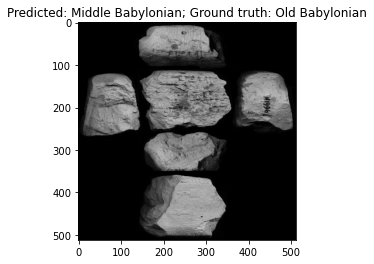

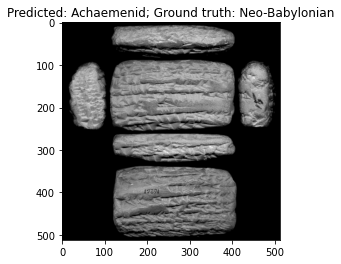

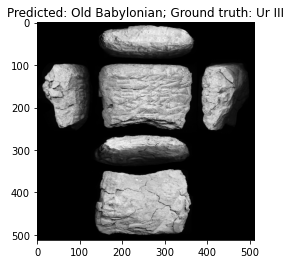

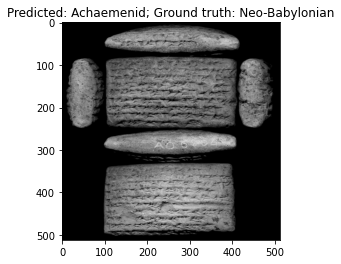

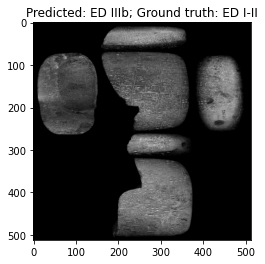

In [70]:
for idx in mistake_indices[:5]:
    
    X, y = ds_test[idx]
    pred = y_pred[idx]
    
    plt.imshow(X, cmap='gray')
    plt.title(f'Predicted: {idx2period[pred]}; Ground truth: {idx2period[y]}')
    plt.show()

# Explain predictions with Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [71]:
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [72]:
# def preprocess_transform(img):
#     return img

In [73]:
# def batch_predict(X):
#     assert len(X.shape) == 4
#     # Lime adds channel dimension (gray2rgb); we remove it
#     # it also requires float64 (double) but our model needs float32
#     X_gray = X[..., 0].astype(np.float32) / 255
#     logits = model(torch.tensor(X_gray).to(device)).detach().cpu().numpy()
# #     probs = clf.predict_proba(logits)
#     probs = scipy.special.softmax(logits, axis=-1)
#     return probs

In [74]:
# explainer = lime_image.LimeImageExplainer()

In [75]:
# def explain_idx(idx):
#     X, y = ds_test[idx]
    
#     explanation = explainer.explain_instance(
#         X.astype(np.float64) * 255,
#         batch_predict,
#     #     top_labels=3,
#     #     hide_color=0,
#         batch_size=16,
#         num_samples=1000
#     )
    
#     top_label = explanation.top_labels[0]
    
#     temp, mask = explanation.get_image_and_mask(
#         top_label,
#         positive_only=False,
#         num_features=20,
#         hide_rest=False
#     )
    
#     img_boundary = mark_boundaries(temp/255.0, mask)
    
#     print(f'Item {idx}:')
#     print(f'Ground truth:\t{ERAS_SHORT[y]} ({y})')
#     print(f'Prediction:\t{ERAS_SHORT[top_label]} ({top_label})')

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     axs[0].imshow(X, cmap='gray');
#     axs[1].imshow(img_boundary);
#     plt.show()

In [72]:
# for i in range(10):
#     explain_idx(i)